# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'
device = 'cuda'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [
        Resize(size),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from typing import Tuple, Callable
import os
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        # List all files in the directory with the given extension
        self.image_files = [f for f in os.listdir(directory) if f.endswith(extension)]

    def __len__(self) -> int:
        """Returns the number of items in the dataset"""
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """Loads an image, applies the transformation, and returns it"""
        # Get the file name of the image at the given index
        image_path = os.path.join(self.directory, self.image_files[index])
        # Open the image using PIL
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations if provided
        if self.transforms:
            image = self.transforms(image)
        
        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

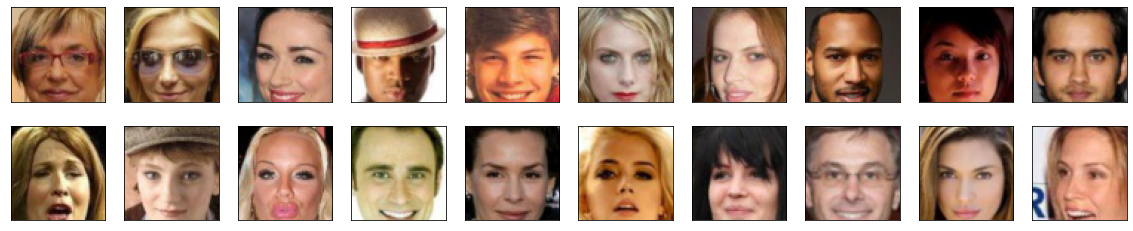

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch.nn as nn

In [30]:
class Noise(nn.Module):
    def __init__(self, channels):
        super(ApplyNoise,self).__init__()
        self.channel = channel
        self.weight = nn.Parameter(torch.zeros(1, self.channel, 1,  1)).to(device)                                                    
    def forward(self, x: torch.Tensor):
        x = x.to(device)
        noise = torch.rand(1, 1, x.shape[2], x.shape[3]).to(device)
        x = x + self.weight * noise

        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            Noise(64),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            Noise(128),
            
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            Noise(256),
            
            nn.Conv2d(256, 512, 4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Fully connected layers
        self.fc = nn.Linear(512 * 5 * 5, 1) # Single output score
        
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.unsqueeze(x, 2) 
        x = torch.unsqueeze(x, 3)
        return x  # Output shape is (batch_size, 1)


In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator().to(device)
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [12]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim: int = 128):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, stride=1, padding=0),  # Output: [batch_size, 512, 4, 4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Noise(512),
            
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),         # Output: [batch_size, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Noise(256),
            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),        # Output: [batch_size, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            Noise(128),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),         # Output: [batch_size, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Noise(64),
            
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),           # Output: [batch_size, 3, 64, 64]
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = z.to(device)
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape latent vector to [batch_size, latent_dim, 1, 1]
        return self.conv(z)

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim).to(device)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits):
    """Generator loss, takes the fake scores as inputs."""
    labels = torch.ones(fake_logits.size()) * 0.9  # Create smoothed labels
    labels = labels.to(fake_logits.device)        # Ensure labels are on the same device
    g_criterion = nn.BCEWithLogitsLoss()
    loss = g_criterion(fake_logits.squeeze(), labels.squeeze())
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits):
    """Discriminator loss, takes the fake and real logits as inputs."""
    r_labels = torch.ones(real_logits.size()) * 0.9  # Smoothed real labels
    r_labels = r_labels.to(real_logits.device)       # Ensure labels are on the same device
    d_criterion = nn.BCEWithLogitsLoss()
    r_loss = d_criterion(real_logits.squeeze(), r_labels.squeeze())

    f_labels = torch.zeros(fake_logits.size())       # Fake labels
    f_labels = f_labels.to(fake_logits.device)
    f_loss = d_criterion(fake_logits.squeeze(), f_labels.squeeze())

    loss = r_loss + f_loss
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones_like(d_interpolates, device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)  # Flatten gradients
    grad_norm = gradients.norm(2, dim=1)  # L2 norm
    penalty = ((grad_norm - 1) ** 2).mean()
    return penalty  # Return as tensor


## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """One training step of the generator."""
    g_optimizer.zero_grad()  # Clear generator gradients

    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    z = torch.from_numpy(z).float().to(device)

    fake_out = generator(z)  
    fake_images = discriminator(fake_out) 

    g_loss = generator_loss(fake_images)
    g_loss.backward()  
    g_optimizer.step()  

    return {'loss': g_loss.item()}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """One training step of the discriminator."""
    d_optimizer.zero_grad() 

    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))  
    z = torch.from_numpy(z).float().to(device)

    fake_images = generator(z).detach()  
    real_logits = discriminator(real_images) 
    fake_logits = discriminator(fake_images)  

    d_loss = discriminator_loss(real_logits, fake_logits)
    gp = gradient_penalty(discriminator, real_images, fake_images)  
    d_loss += gp  #

    d_loss.backward()  
    d_optimizer.step()  

    return {'loss': d_loss.item(), 'gp': gp.item()} 

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [27]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30
# number of images in each batch
batch_size = 64

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-11-23 16:59:49 | Epoch [1/30] | Batch 0/509 | d_loss: 1.2299 | g_loss: 1.6747
2024-11-23 16:59:58 | Epoch [1/30] | Batch 50/509 | d_loss: 1.3023 | g_loss: 1.4205
2024-11-23 17:00:09 | Epoch [1/30] | Batch 100/509 | d_loss: 1.3606 | g_loss: 1.4446
2024-11-23 17:00:23 | Epoch [1/30] | Batch 150/509 | d_loss: 1.3044 | g_loss: 0.7730
2024-11-23 17:00:38 | Epoch [1/30] | Batch 200/509 | d_loss: 1.2473 | g_loss: 1.0649
2024-11-23 17:00:54 | Epoch [1/30] | Batch 250/509 | d_loss: 1.3378 | g_loss: 0.8899
2024-11-23 17:01:18 | Epoch [1/30] | Batch 300/509 | d_loss: 1.2926 | g_loss: 0.8653
2024-11-23 17:01:45 | Epoch [1/30] | Batch 350/509 | d_loss: 1.2862 | g_loss: 1.1111
2024-11-23 17:02:15 | Epoch [1/30] | Batch 400/509 | d_loss: 1.2396 | g_loss: 1.0857
2024-11-23 17:02:45 | Epoch [1/30] | Batch 450/509 | d_loss: 1.3361 | g_loss: 1.1440
2024-11-23 17:03:16 | Epoch [1/30] | Batch 500/509 | d_loss: 1.2174 | g_loss: 1.1445


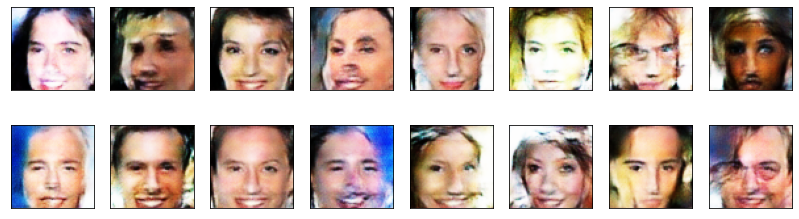

2024-11-23 17:03:25 | Epoch [2/30] | Batch 0/509 | d_loss: 1.3032 | g_loss: 1.1854
2024-11-23 17:03:34 | Epoch [2/30] | Batch 50/509 | d_loss: 1.2925 | g_loss: 1.5112
2024-11-23 17:03:45 | Epoch [2/30] | Batch 100/509 | d_loss: 1.2741 | g_loss: 1.0134
2024-11-23 17:03:58 | Epoch [2/30] | Batch 150/509 | d_loss: 1.3220 | g_loss: 0.9788
2024-11-23 17:04:13 | Epoch [2/30] | Batch 200/509 | d_loss: 1.2589 | g_loss: 1.0637
2024-11-23 17:04:29 | Epoch [2/30] | Batch 250/509 | d_loss: 1.2532 | g_loss: 0.8860
2024-11-23 17:04:53 | Epoch [2/30] | Batch 300/509 | d_loss: 1.3014 | g_loss: 0.9567
2024-11-23 17:05:20 | Epoch [2/30] | Batch 350/509 | d_loss: 1.1813 | g_loss: 1.1987
2024-11-23 17:05:50 | Epoch [2/30] | Batch 400/509 | d_loss: 1.2933 | g_loss: 0.9238
2024-11-23 17:06:20 | Epoch [2/30] | Batch 450/509 | d_loss: 1.2982 | g_loss: 0.9804
2024-11-23 17:06:50 | Epoch [2/30] | Batch 500/509 | d_loss: 1.3292 | g_loss: 1.5018


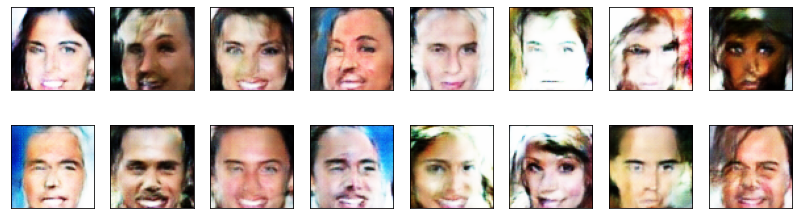

2024-11-23 17:07:00 | Epoch [3/30] | Batch 0/509 | d_loss: 1.2982 | g_loss: 1.6099
2024-11-23 17:07:10 | Epoch [3/30] | Batch 50/509 | d_loss: 1.1872 | g_loss: 1.0234
2024-11-23 17:07:20 | Epoch [3/30] | Batch 100/509 | d_loss: 1.3413 | g_loss: 0.7812
2024-11-23 17:07:33 | Epoch [3/30] | Batch 150/509 | d_loss: 1.6127 | g_loss: 0.7194
2024-11-23 17:07:48 | Epoch [3/30] | Batch 200/509 | d_loss: 1.1961 | g_loss: 0.9692
2024-11-23 17:08:04 | Epoch [3/30] | Batch 250/509 | d_loss: 1.3074 | g_loss: 1.6750
2024-11-23 17:08:29 | Epoch [3/30] | Batch 300/509 | d_loss: 1.2736 | g_loss: 1.1425
2024-11-23 17:08:56 | Epoch [3/30] | Batch 350/509 | d_loss: 1.7089 | g_loss: 1.4599
2024-11-23 17:09:25 | Epoch [3/30] | Batch 400/509 | d_loss: 1.3027 | g_loss: 0.9920
2024-11-23 17:09:55 | Epoch [3/30] | Batch 450/509 | d_loss: 1.2990 | g_loss: 0.9625
2024-11-23 17:10:26 | Epoch [3/30] | Batch 500/509 | d_loss: 1.2536 | g_loss: 0.8155


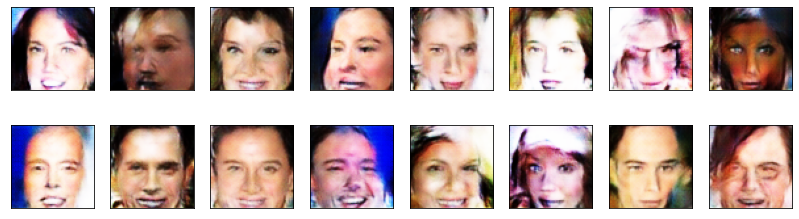

2024-11-23 17:10:35 | Epoch [4/30] | Batch 0/509 | d_loss: 1.2568 | g_loss: 0.9238
2024-11-23 17:10:45 | Epoch [4/30] | Batch 50/509 | d_loss: 1.1937 | g_loss: 0.9874
2024-11-23 17:10:56 | Epoch [4/30] | Batch 100/509 | d_loss: 1.2102 | g_loss: 1.0038
2024-11-23 17:11:09 | Epoch [4/30] | Batch 150/509 | d_loss: 1.3919 | g_loss: 1.8512
2024-11-23 17:11:24 | Epoch [4/30] | Batch 200/509 | d_loss: 1.3158 | g_loss: 1.1538
2024-11-23 17:11:40 | Epoch [4/30] | Batch 250/509 | d_loss: 1.2741 | g_loss: 0.8814
2024-11-23 17:12:04 | Epoch [4/30] | Batch 300/509 | d_loss: 1.3191 | g_loss: 1.2062
2024-11-23 17:12:32 | Epoch [4/30] | Batch 350/509 | d_loss: 1.3247 | g_loss: 0.9128
2024-11-23 17:13:01 | Epoch [4/30] | Batch 400/509 | d_loss: 1.2982 | g_loss: 0.8822
2024-11-23 17:13:31 | Epoch [4/30] | Batch 450/509 | d_loss: 1.3443 | g_loss: 1.0001
2024-11-23 17:14:02 | Epoch [4/30] | Batch 500/509 | d_loss: 1.2217 | g_loss: 1.0175


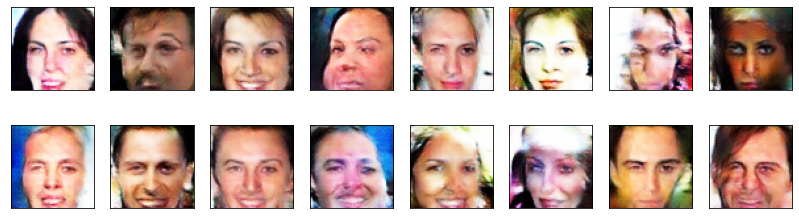

2024-11-23 17:14:11 | Epoch [5/30] | Batch 0/509 | d_loss: 1.3095 | g_loss: 0.7646
2024-11-23 17:14:20 | Epoch [5/30] | Batch 50/509 | d_loss: 1.2297 | g_loss: 0.9963
2024-11-23 17:14:31 | Epoch [5/30] | Batch 100/509 | d_loss: 1.2829 | g_loss: 0.9261
2024-11-23 17:14:44 | Epoch [5/30] | Batch 150/509 | d_loss: 1.1489 | g_loss: 1.0758
2024-11-23 17:14:59 | Epoch [5/30] | Batch 200/509 | d_loss: 1.2440 | g_loss: 0.8071
2024-11-23 17:15:15 | Epoch [5/30] | Batch 250/509 | d_loss: 1.1624 | g_loss: 1.0379
2024-11-23 17:15:39 | Epoch [5/30] | Batch 300/509 | d_loss: 1.5562 | g_loss: 0.7312
2024-11-23 17:16:07 | Epoch [5/30] | Batch 350/509 | d_loss: 1.2876 | g_loss: 0.9512
2024-11-23 17:16:37 | Epoch [5/30] | Batch 400/509 | d_loss: 1.4470 | g_loss: 0.8982
2024-11-23 17:17:07 | Epoch [5/30] | Batch 450/509 | d_loss: 1.2636 | g_loss: 0.8922
2024-11-23 17:17:38 | Epoch [5/30] | Batch 500/509 | d_loss: 1.3187 | g_loss: 1.0450


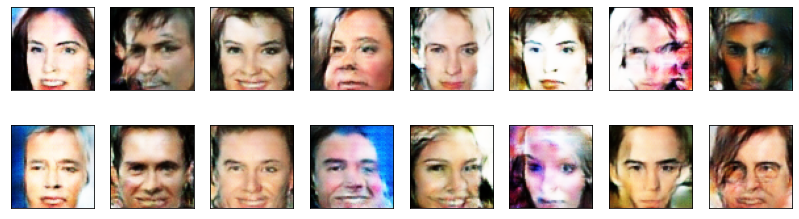

2024-11-23 17:17:48 | Epoch [6/30] | Batch 0/509 | d_loss: 1.2672 | g_loss: 0.7966
2024-11-23 17:17:58 | Epoch [6/30] | Batch 50/509 | d_loss: 1.3118 | g_loss: 1.5055
2024-11-23 17:18:09 | Epoch [6/30] | Batch 100/509 | d_loss: 1.2636 | g_loss: 1.0383
2024-11-23 17:18:22 | Epoch [6/30] | Batch 150/509 | d_loss: 1.2909 | g_loss: 0.9552
2024-11-23 17:18:37 | Epoch [6/30] | Batch 200/509 | d_loss: 1.1941 | g_loss: 0.9609
2024-11-23 17:18:53 | Epoch [6/30] | Batch 250/509 | d_loss: 1.2780 | g_loss: 0.8782
2024-11-23 17:19:17 | Epoch [6/30] | Batch 300/509 | d_loss: 1.2323 | g_loss: 0.9512
2024-11-23 17:19:44 | Epoch [6/30] | Batch 350/509 | d_loss: 1.3829 | g_loss: 0.7277
2024-11-23 17:20:14 | Epoch [6/30] | Batch 400/509 | d_loss: 1.1975 | g_loss: 0.9994
2024-11-23 17:20:44 | Epoch [6/30] | Batch 450/509 | d_loss: 1.2113 | g_loss: 1.2382
2024-11-23 17:21:15 | Epoch [6/30] | Batch 500/509 | d_loss: 1.1672 | g_loss: 1.1122


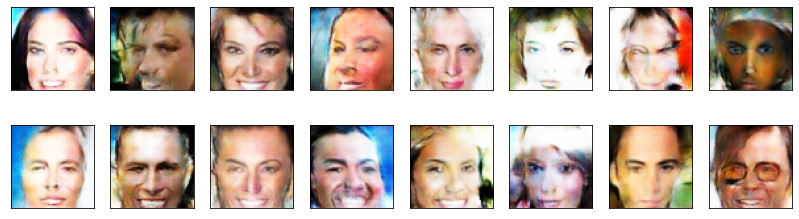

2024-11-23 17:21:25 | Epoch [7/30] | Batch 0/509 | d_loss: 1.2645 | g_loss: 1.1540
2024-11-23 17:21:34 | Epoch [7/30] | Batch 50/509 | d_loss: 1.2137 | g_loss: 1.0582
2024-11-23 17:21:45 | Epoch [7/30] | Batch 100/509 | d_loss: 1.1526 | g_loss: 1.2049
2024-11-23 17:21:58 | Epoch [7/30] | Batch 150/509 | d_loss: 1.3392 | g_loss: 1.2584
2024-11-23 17:22:13 | Epoch [7/30] | Batch 200/509 | d_loss: 1.3226 | g_loss: 1.0356
2024-11-23 17:22:29 | Epoch [7/30] | Batch 250/509 | d_loss: 1.2743 | g_loss: 1.0543
2024-11-23 17:22:54 | Epoch [7/30] | Batch 300/509 | d_loss: 1.3133 | g_loss: 0.8185
2024-11-23 17:23:22 | Epoch [7/30] | Batch 350/509 | d_loss: 1.4411 | g_loss: 0.6633
2024-11-23 17:23:51 | Epoch [7/30] | Batch 400/509 | d_loss: 1.3385 | g_loss: 0.7953
2024-11-23 17:24:21 | Epoch [7/30] | Batch 450/509 | d_loss: 1.3024 | g_loss: 0.8994
2024-11-23 17:24:52 | Epoch [7/30] | Batch 500/509 | d_loss: 1.2403 | g_loss: 1.1611


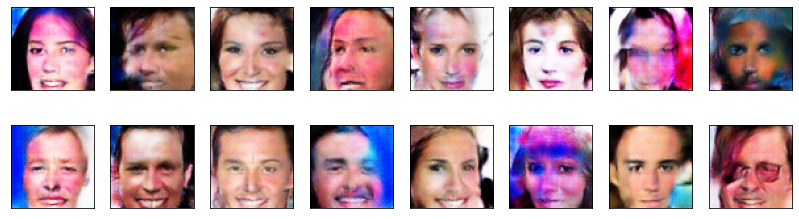

2024-11-23 17:25:01 | Epoch [8/30] | Batch 0/509 | d_loss: 1.2555 | g_loss: 0.9658
2024-11-23 17:25:11 | Epoch [8/30] | Batch 50/509 | d_loss: 1.1876 | g_loss: 1.2956
2024-11-23 17:25:22 | Epoch [8/30] | Batch 100/509 | d_loss: 1.1745 | g_loss: 1.1905
2024-11-23 17:25:35 | Epoch [8/30] | Batch 150/509 | d_loss: 1.2246 | g_loss: 1.0796
2024-11-23 17:25:50 | Epoch [8/30] | Batch 200/509 | d_loss: 1.2507 | g_loss: 0.9870
2024-11-23 17:26:06 | Epoch [8/30] | Batch 250/509 | d_loss: 1.2497 | g_loss: 1.0633
2024-11-23 17:26:30 | Epoch [8/30] | Batch 300/509 | d_loss: 1.2456 | g_loss: 1.0035
2024-11-23 17:26:58 | Epoch [8/30] | Batch 350/509 | d_loss: 1.1761 | g_loss: 1.2363
2024-11-23 17:27:28 | Epoch [8/30] | Batch 400/509 | d_loss: 1.1953 | g_loss: 1.1480
2024-11-23 17:27:58 | Epoch [8/30] | Batch 450/509 | d_loss: 1.2877 | g_loss: 1.1259
2024-11-23 17:28:29 | Epoch [8/30] | Batch 500/509 | d_loss: 1.2212 | g_loss: 0.9667


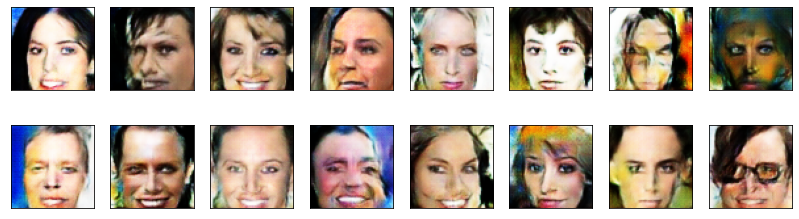

2024-11-23 17:28:38 | Epoch [9/30] | Batch 0/509 | d_loss: 1.2207 | g_loss: 1.2139
2024-11-23 17:28:47 | Epoch [9/30] | Batch 50/509 | d_loss: 1.3035 | g_loss: 1.3787
2024-11-23 17:28:58 | Epoch [9/30] | Batch 100/509 | d_loss: 1.2368 | g_loss: 0.9557
2024-11-23 17:29:11 | Epoch [9/30] | Batch 150/509 | d_loss: 1.2507 | g_loss: 1.1276
2024-11-23 17:29:26 | Epoch [9/30] | Batch 200/509 | d_loss: 1.1365 | g_loss: 1.1203
2024-11-23 17:29:42 | Epoch [9/30] | Batch 250/509 | d_loss: 1.1893 | g_loss: 1.5781
2024-11-23 17:30:06 | Epoch [9/30] | Batch 300/509 | d_loss: 1.2933 | g_loss: 0.8622
2024-11-23 17:30:34 | Epoch [9/30] | Batch 350/509 | d_loss: 1.2024 | g_loss: 1.2122
2024-11-23 17:31:03 | Epoch [9/30] | Batch 400/509 | d_loss: 1.2696 | g_loss: 0.9186
2024-11-23 17:31:33 | Epoch [9/30] | Batch 450/509 | d_loss: 1.3602 | g_loss: 1.2976
2024-11-23 17:32:04 | Epoch [9/30] | Batch 500/509 | d_loss: 1.3673 | g_loss: 0.8039


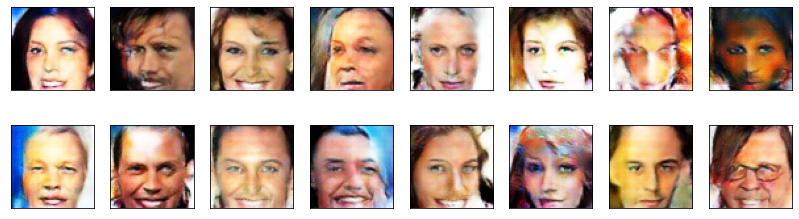

2024-11-23 17:32:12 | Epoch [10/30] | Batch 0/509 | d_loss: 1.2810 | g_loss: 1.0405
2024-11-23 17:32:22 | Epoch [10/30] | Batch 50/509 | d_loss: 1.2732 | g_loss: 0.9150
2024-11-23 17:32:33 | Epoch [10/30] | Batch 100/509 | d_loss: 1.2423 | g_loss: 0.8958
2024-11-23 17:32:46 | Epoch [10/30] | Batch 150/509 | d_loss: 1.3424 | g_loss: 0.7231
2024-11-23 17:33:01 | Epoch [10/30] | Batch 200/509 | d_loss: 1.2992 | g_loss: 0.8359
2024-11-23 17:33:17 | Epoch [10/30] | Batch 250/509 | d_loss: 1.1047 | g_loss: 1.2136
2024-11-23 17:33:41 | Epoch [10/30] | Batch 300/509 | d_loss: 1.1698 | g_loss: 1.0037
2024-11-23 17:34:08 | Epoch [10/30] | Batch 350/509 | d_loss: 1.3908 | g_loss: 0.7421
2024-11-23 17:34:38 | Epoch [10/30] | Batch 400/509 | d_loss: 1.3204 | g_loss: 0.8423
2024-11-23 17:35:08 | Epoch [10/30] | Batch 450/509 | d_loss: 1.3204 | g_loss: 0.8053
2024-11-23 17:35:39 | Epoch [10/30] | Batch 500/509 | d_loss: 1.2166 | g_loss: 0.9281


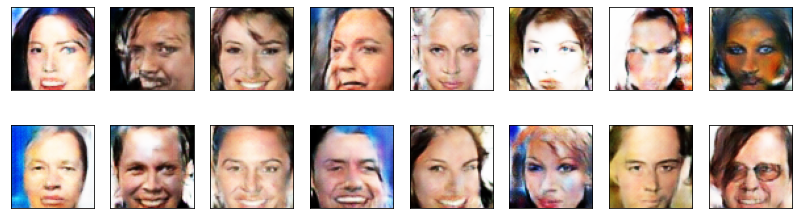

2024-11-23 17:35:48 | Epoch [11/30] | Batch 0/509 | d_loss: 1.2243 | g_loss: 1.1238
2024-11-23 17:35:57 | Epoch [11/30] | Batch 50/509 | d_loss: 1.2000 | g_loss: 1.0812
2024-11-23 17:36:08 | Epoch [11/30] | Batch 100/509 | d_loss: 1.1463 | g_loss: 1.0241
2024-11-23 17:36:21 | Epoch [11/30] | Batch 150/509 | d_loss: 1.2915 | g_loss: 0.9676
2024-11-23 17:36:36 | Epoch [11/30] | Batch 200/509 | d_loss: 1.2669 | g_loss: 0.8957
2024-11-23 17:36:53 | Epoch [11/30] | Batch 250/509 | d_loss: 1.2108 | g_loss: 1.0053
2024-11-23 17:37:17 | Epoch [11/30] | Batch 300/509 | d_loss: 1.2048 | g_loss: 0.9183
2024-11-23 17:37:44 | Epoch [11/30] | Batch 350/509 | d_loss: 1.2298 | g_loss: 1.5303
2024-11-23 17:38:14 | Epoch [11/30] | Batch 400/509 | d_loss: 1.1772 | g_loss: 1.0019
2024-11-23 17:38:44 | Epoch [11/30] | Batch 450/509 | d_loss: 1.3227 | g_loss: 1.0327
2024-11-23 17:39:15 | Epoch [11/30] | Batch 500/509 | d_loss: 1.3133 | g_loss: 0.9154


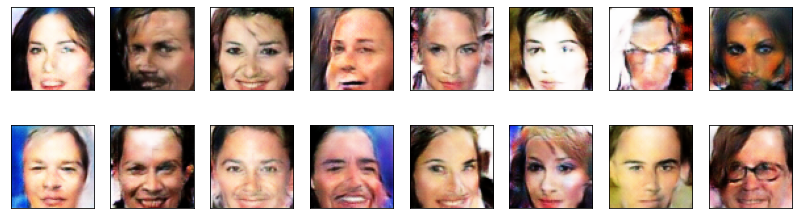

2024-11-23 17:39:23 | Epoch [12/30] | Batch 0/509 | d_loss: 1.2052 | g_loss: 1.0013
2024-11-23 17:39:33 | Epoch [12/30] | Batch 50/509 | d_loss: 1.3219 | g_loss: 0.8456
2024-11-23 17:39:44 | Epoch [12/30] | Batch 100/509 | d_loss: 1.1862 | g_loss: 1.1780
2024-11-23 17:39:57 | Epoch [12/30] | Batch 150/509 | d_loss: 1.7647 | g_loss: 1.1288
2024-11-23 17:40:11 | Epoch [12/30] | Batch 200/509 | d_loss: 1.5136 | g_loss: 1.3944
2024-11-23 17:40:28 | Epoch [12/30] | Batch 250/509 | d_loss: 1.4755 | g_loss: 0.7035
2024-11-23 17:40:52 | Epoch [12/30] | Batch 300/509 | d_loss: 1.4092 | g_loss: 0.9242
2024-11-23 17:41:19 | Epoch [12/30] | Batch 350/509 | d_loss: 1.4109 | g_loss: 0.8344
2024-11-23 17:41:48 | Epoch [12/30] | Batch 400/509 | d_loss: 1.4314 | g_loss: 0.8904
2024-11-23 17:42:18 | Epoch [12/30] | Batch 450/509 | d_loss: 1.4366 | g_loss: 0.9447
2024-11-23 17:42:49 | Epoch [12/30] | Batch 500/509 | d_loss: 1.3870 | g_loss: 0.7935


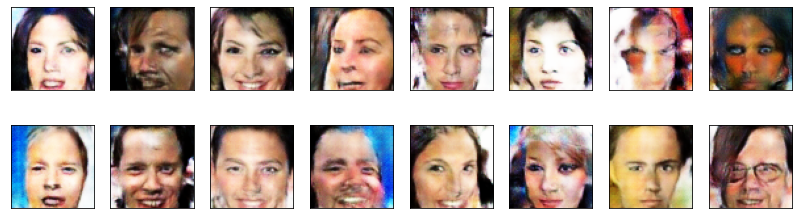

2024-11-23 17:42:59 | Epoch [13/30] | Batch 0/509 | d_loss: 1.3700 | g_loss: 0.8909
2024-11-23 17:43:08 | Epoch [13/30] | Batch 50/509 | d_loss: 1.4263 | g_loss: 0.6257
2024-11-23 17:43:19 | Epoch [13/30] | Batch 100/509 | d_loss: 1.4419 | g_loss: 0.6585
2024-11-23 17:43:32 | Epoch [13/30] | Batch 150/509 | d_loss: 1.3109 | g_loss: 0.8674
2024-11-23 17:43:47 | Epoch [13/30] | Batch 200/509 | d_loss: 1.3726 | g_loss: 0.8325
2024-11-23 17:44:03 | Epoch [13/30] | Batch 250/509 | d_loss: 1.3871 | g_loss: 0.6750
2024-11-23 17:44:27 | Epoch [13/30] | Batch 300/509 | d_loss: 1.3348 | g_loss: 0.7989
2024-11-23 17:44:55 | Epoch [13/30] | Batch 350/509 | d_loss: 1.3435 | g_loss: 1.1309
2024-11-23 17:45:24 | Epoch [13/30] | Batch 400/509 | d_loss: 1.3099 | g_loss: 0.7774
2024-11-23 17:45:54 | Epoch [13/30] | Batch 450/509 | d_loss: 1.2952 | g_loss: 1.0181
2024-11-23 17:46:25 | Epoch [13/30] | Batch 500/509 | d_loss: 1.3093 | g_loss: 0.9083


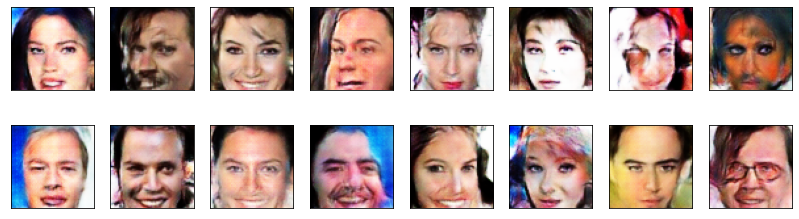

2024-11-23 17:46:34 | Epoch [14/30] | Batch 0/509 | d_loss: 1.2763 | g_loss: 0.8544
2024-11-23 17:46:44 | Epoch [14/30] | Batch 50/509 | d_loss: 1.3329 | g_loss: 0.8186
2024-11-23 17:46:55 | Epoch [14/30] | Batch 100/509 | d_loss: 1.2854 | g_loss: 0.9496
2024-11-23 17:47:08 | Epoch [14/30] | Batch 150/509 | d_loss: 1.3122 | g_loss: 0.7046
2024-11-23 17:47:23 | Epoch [14/30] | Batch 200/509 | d_loss: 1.4900 | g_loss: 0.6911
2024-11-23 17:47:39 | Epoch [14/30] | Batch 250/509 | d_loss: 1.2854 | g_loss: 0.7923
2024-11-23 17:48:03 | Epoch [14/30] | Batch 300/509 | d_loss: 1.2614 | g_loss: 0.8722
2024-11-23 17:48:30 | Epoch [14/30] | Batch 350/509 | d_loss: 1.3002 | g_loss: 0.9585
2024-11-23 17:49:00 | Epoch [14/30] | Batch 400/509 | d_loss: 1.2720 | g_loss: 1.0211
2024-11-23 17:49:30 | Epoch [14/30] | Batch 450/509 | d_loss: 1.2037 | g_loss: 0.9178
2024-11-23 17:50:00 | Epoch [14/30] | Batch 500/509 | d_loss: 1.2601 | g_loss: 0.8741


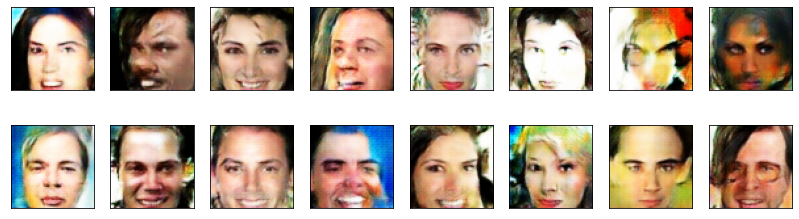

2024-11-23 17:50:09 | Epoch [15/30] | Batch 0/509 | d_loss: 1.2765 | g_loss: 1.1523
2024-11-23 17:50:19 | Epoch [15/30] | Batch 50/509 | d_loss: 1.2641 | g_loss: 0.9032
2024-11-23 17:50:30 | Epoch [15/30] | Batch 100/509 | d_loss: 1.2455 | g_loss: 0.9625
2024-11-23 17:50:43 | Epoch [15/30] | Batch 150/509 | d_loss: 1.2955 | g_loss: 0.8367
2024-11-23 17:50:58 | Epoch [15/30] | Batch 200/509 | d_loss: 1.1546 | g_loss: 1.0569
2024-11-23 17:51:14 | Epoch [15/30] | Batch 250/509 | d_loss: 1.3489 | g_loss: 1.0208
2024-11-23 17:51:38 | Epoch [15/30] | Batch 300/509 | d_loss: 1.2252 | g_loss: 0.9262
2024-11-23 17:52:05 | Epoch [15/30] | Batch 350/509 | d_loss: 1.2292 | g_loss: 0.9670
2024-11-23 17:52:35 | Epoch [15/30] | Batch 400/509 | d_loss: 1.2453 | g_loss: 1.1755
2024-11-23 17:53:05 | Epoch [15/30] | Batch 450/509 | d_loss: 1.1801 | g_loss: 1.0689
2024-11-23 17:53:35 | Epoch [15/30] | Batch 500/509 | d_loss: 1.2040 | g_loss: 1.2356


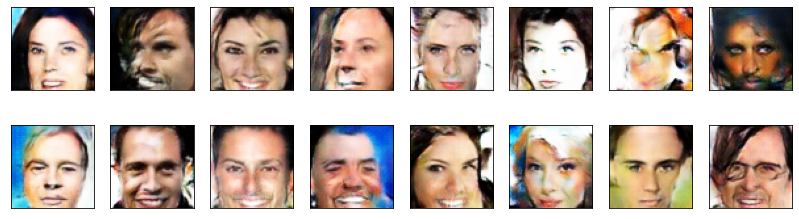

2024-11-23 17:53:44 | Epoch [16/30] | Batch 0/509 | d_loss: 1.1794 | g_loss: 1.1059
2024-11-23 17:53:54 | Epoch [16/30] | Batch 50/509 | d_loss: 1.3857 | g_loss: 0.9436
2024-11-23 17:54:05 | Epoch [16/30] | Batch 100/509 | d_loss: 1.2739 | g_loss: 0.9766
2024-11-23 17:54:18 | Epoch [16/30] | Batch 150/509 | d_loss: 1.2669 | g_loss: 0.9024
2024-11-23 17:54:33 | Epoch [16/30] | Batch 200/509 | d_loss: 1.2338 | g_loss: 1.0108
2024-11-23 17:54:49 | Epoch [16/30] | Batch 250/509 | d_loss: 1.2571 | g_loss: 0.7634
2024-11-23 17:55:13 | Epoch [16/30] | Batch 300/509 | d_loss: 1.3333 | g_loss: 1.1046
2024-11-23 17:55:41 | Epoch [16/30] | Batch 350/509 | d_loss: 1.2862 | g_loss: 0.7394
2024-11-23 17:56:10 | Epoch [16/30] | Batch 400/509 | d_loss: 1.2189 | g_loss: 0.8675
2024-11-23 17:56:40 | Epoch [16/30] | Batch 450/509 | d_loss: 1.2424 | g_loss: 1.2280
2024-11-23 17:57:11 | Epoch [16/30] | Batch 500/509 | d_loss: 1.1399 | g_loss: 0.9070


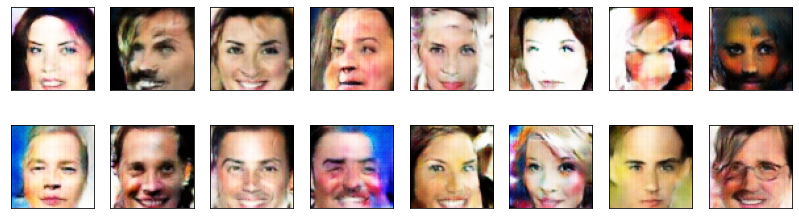

2024-11-23 17:57:19 | Epoch [17/30] | Batch 0/509 | d_loss: 1.3246 | g_loss: 1.0992
2024-11-23 17:57:29 | Epoch [17/30] | Batch 50/509 | d_loss: 1.3227 | g_loss: 1.1782
2024-11-23 17:57:40 | Epoch [17/30] | Batch 100/509 | d_loss: 1.0866 | g_loss: 1.4714
2024-11-23 17:57:52 | Epoch [17/30] | Batch 150/509 | d_loss: 1.1930 | g_loss: 1.3124
2024-11-23 17:58:07 | Epoch [17/30] | Batch 200/509 | d_loss: 1.2605 | g_loss: 0.8416
2024-11-23 17:58:23 | Epoch [17/30] | Batch 250/509 | d_loss: 1.5078 | g_loss: 1.9510
2024-11-23 17:58:48 | Epoch [17/30] | Batch 300/509 | d_loss: 1.2255 | g_loss: 0.9805
2024-11-23 17:59:15 | Epoch [17/30] | Batch 350/509 | d_loss: 1.1154 | g_loss: 1.0314
2024-11-23 17:59:44 | Epoch [17/30] | Batch 400/509 | d_loss: 1.3421 | g_loss: 0.8731
2024-11-23 18:00:14 | Epoch [17/30] | Batch 450/509 | d_loss: 1.2712 | g_loss: 1.1726
2024-11-23 18:00:45 | Epoch [17/30] | Batch 500/509 | d_loss: 1.2701 | g_loss: 1.0701


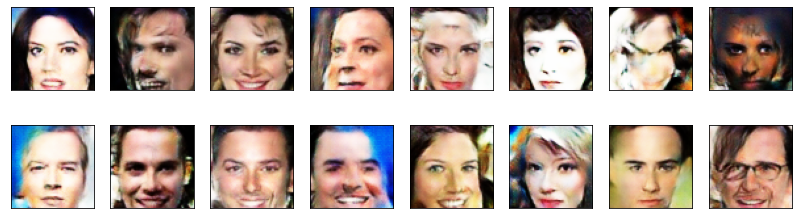

2024-11-23 18:00:55 | Epoch [18/30] | Batch 0/509 | d_loss: 1.2143 | g_loss: 0.8324
2024-11-23 18:01:05 | Epoch [18/30] | Batch 50/509 | d_loss: 1.1484 | g_loss: 1.0052
2024-11-23 18:01:16 | Epoch [18/30] | Batch 100/509 | d_loss: 1.1987 | g_loss: 1.2961
2024-11-23 18:01:28 | Epoch [18/30] | Batch 150/509 | d_loss: 1.2846 | g_loss: 0.9679
2024-11-23 18:01:43 | Epoch [18/30] | Batch 200/509 | d_loss: 1.2288 | g_loss: 1.0354
2024-11-23 18:01:59 | Epoch [18/30] | Batch 250/509 | d_loss: 1.1746 | g_loss: 1.2598
2024-11-23 18:02:24 | Epoch [18/30] | Batch 300/509 | d_loss: 1.1131 | g_loss: 1.1034
2024-11-23 18:02:51 | Epoch [18/30] | Batch 350/509 | d_loss: 1.1536 | g_loss: 1.4332
2024-11-23 18:03:20 | Epoch [18/30] | Batch 400/509 | d_loss: 1.1661 | g_loss: 1.3224
2024-11-23 18:03:51 | Epoch [18/30] | Batch 450/509 | d_loss: 1.0239 | g_loss: 1.2370
2024-11-23 18:04:21 | Epoch [18/30] | Batch 500/509 | d_loss: 1.1236 | g_loss: 1.2039


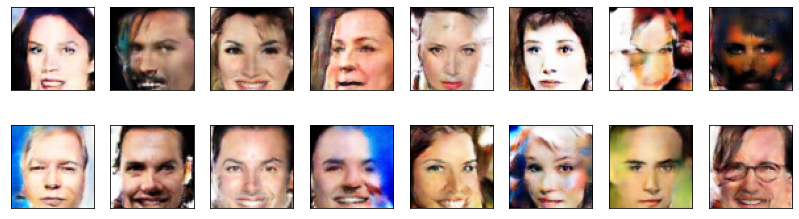

2024-11-23 18:04:30 | Epoch [19/30] | Batch 0/509 | d_loss: 1.2764 | g_loss: 0.7129
2024-11-23 18:04:40 | Epoch [19/30] | Batch 50/509 | d_loss: 1.2753 | g_loss: 1.2179
2024-11-23 18:04:50 | Epoch [19/30] | Batch 100/509 | d_loss: 1.1111 | g_loss: 1.2774
2024-11-23 18:05:03 | Epoch [19/30] | Batch 150/509 | d_loss: 1.6643 | g_loss: 0.5955
2024-11-23 18:05:18 | Epoch [19/30] | Batch 200/509 | d_loss: 1.1020 | g_loss: 1.0784
2024-11-23 18:05:34 | Epoch [19/30] | Batch 250/509 | d_loss: 1.3821 | g_loss: 0.8235
2024-11-23 18:05:59 | Epoch [19/30] | Batch 300/509 | d_loss: 1.3716 | g_loss: 0.7570
2024-11-23 18:06:26 | Epoch [19/30] | Batch 350/509 | d_loss: 1.2879 | g_loss: 0.7254
2024-11-23 18:06:55 | Epoch [19/30] | Batch 400/509 | d_loss: 1.3092 | g_loss: 0.8024
2024-11-23 18:07:25 | Epoch [19/30] | Batch 450/509 | d_loss: 1.2034 | g_loss: 0.9210
2024-11-23 18:07:56 | Epoch [19/30] | Batch 500/509 | d_loss: 1.2708 | g_loss: 0.8703


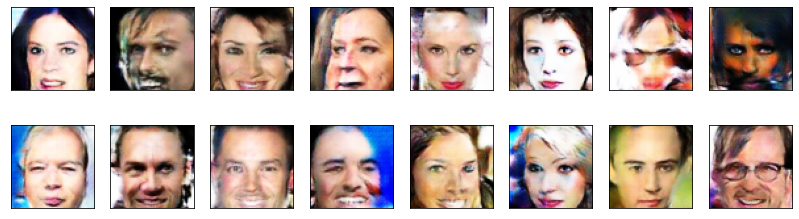

2024-11-23 18:08:05 | Epoch [20/30] | Batch 0/509 | d_loss: 1.0991 | g_loss: 1.1184
2024-11-23 18:08:15 | Epoch [20/30] | Batch 50/509 | d_loss: 1.1270 | g_loss: 1.0739
2024-11-23 18:08:26 | Epoch [20/30] | Batch 100/509 | d_loss: 1.7696 | g_loss: 1.9903
2024-11-23 18:08:39 | Epoch [20/30] | Batch 150/509 | d_loss: 1.1459 | g_loss: 0.9161
2024-11-23 18:08:54 | Epoch [20/30] | Batch 200/509 | d_loss: 1.4848 | g_loss: 0.7644
2024-11-23 18:09:10 | Epoch [20/30] | Batch 250/509 | d_loss: 1.2045 | g_loss: 1.1475
2024-11-23 18:09:34 | Epoch [20/30] | Batch 300/509 | d_loss: 1.4421 | g_loss: 0.6777
2024-11-23 18:10:01 | Epoch [20/30] | Batch 350/509 | d_loss: 1.3583 | g_loss: 0.9397
2024-11-23 18:10:31 | Epoch [20/30] | Batch 400/509 | d_loss: 1.3756 | g_loss: 0.7789
2024-11-23 18:11:01 | Epoch [20/30] | Batch 450/509 | d_loss: 1.3509 | g_loss: 0.8512
2024-11-23 18:11:32 | Epoch [20/30] | Batch 500/509 | d_loss: 1.2539 | g_loss: 0.9722


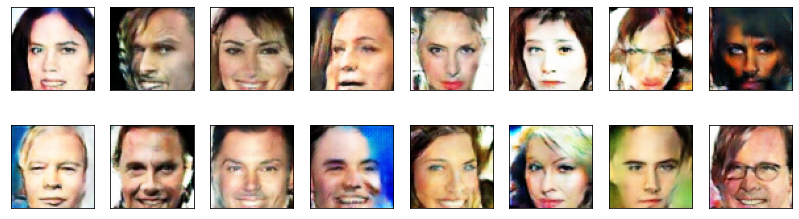

2024-11-23 18:11:41 | Epoch [21/30] | Batch 0/509 | d_loss: 1.2188 | g_loss: 0.9794
2024-11-23 18:11:51 | Epoch [21/30] | Batch 50/509 | d_loss: 1.2275 | g_loss: 0.9167
2024-11-23 18:12:02 | Epoch [21/30] | Batch 100/509 | d_loss: 1.1722 | g_loss: 0.9898
2024-11-23 18:12:15 | Epoch [21/30] | Batch 150/509 | d_loss: 1.2798 | g_loss: 1.0210
2024-11-23 18:12:30 | Epoch [21/30] | Batch 200/509 | d_loss: 1.3206 | g_loss: 0.9745
2024-11-23 18:12:46 | Epoch [21/30] | Batch 250/509 | d_loss: 1.1691 | g_loss: 1.0288
2024-11-23 18:13:10 | Epoch [21/30] | Batch 300/509 | d_loss: 1.2395 | g_loss: 0.8807
2024-11-23 18:13:37 | Epoch [21/30] | Batch 350/509 | d_loss: 1.1948 | g_loss: 1.0642
2024-11-23 18:14:07 | Epoch [21/30] | Batch 400/509 | d_loss: 1.1894 | g_loss: 0.9720
2024-11-23 18:14:37 | Epoch [21/30] | Batch 450/509 | d_loss: 1.2078 | g_loss: 1.0171
2024-11-23 18:15:08 | Epoch [21/30] | Batch 500/509 | d_loss: 1.1068 | g_loss: 1.1227


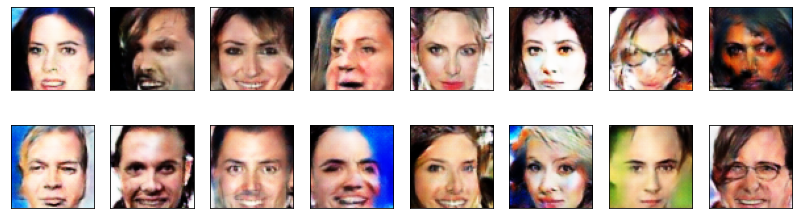

2024-11-23 18:15:17 | Epoch [22/30] | Batch 0/509 | d_loss: 1.1539 | g_loss: 0.9909
2024-11-23 18:15:26 | Epoch [22/30] | Batch 50/509 | d_loss: 1.2510 | g_loss: 1.1575
2024-11-23 18:15:37 | Epoch [22/30] | Batch 100/509 | d_loss: 1.1171 | g_loss: 1.0190
2024-11-23 18:15:50 | Epoch [22/30] | Batch 150/509 | d_loss: 1.1873 | g_loss: 1.3841
2024-11-23 18:16:05 | Epoch [22/30] | Batch 200/509 | d_loss: 1.2626 | g_loss: 0.9017
2024-11-23 18:16:21 | Epoch [22/30] | Batch 250/509 | d_loss: 1.1805 | g_loss: 1.0700
2024-11-23 18:16:45 | Epoch [22/30] | Batch 300/509 | d_loss: 1.2642 | g_loss: 0.8592
2024-11-23 18:17:13 | Epoch [22/30] | Batch 350/509 | d_loss: 1.2316 | g_loss: 0.9234
2024-11-23 18:17:43 | Epoch [22/30] | Batch 400/509 | d_loss: 1.2993 | g_loss: 0.9196
2024-11-23 18:18:13 | Epoch [22/30] | Batch 450/509 | d_loss: 1.1443 | g_loss: 0.9512
2024-11-23 18:18:44 | Epoch [22/30] | Batch 500/509 | d_loss: 1.0935 | g_loss: 1.1237


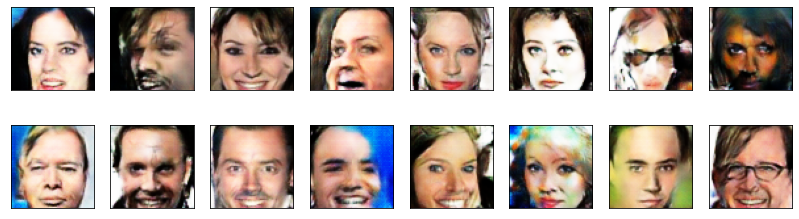

2024-11-23 18:18:53 | Epoch [23/30] | Batch 0/509 | d_loss: 1.1311 | g_loss: 1.3660
2024-11-23 18:19:03 | Epoch [23/30] | Batch 50/509 | d_loss: 1.1732 | g_loss: 0.9493
2024-11-23 18:19:13 | Epoch [23/30] | Batch 100/509 | d_loss: 1.4309 | g_loss: 1.4575
2024-11-23 18:19:26 | Epoch [23/30] | Batch 150/509 | d_loss: 1.2261 | g_loss: 0.7099
2024-11-23 18:19:41 | Epoch [23/30] | Batch 200/509 | d_loss: 1.1801 | g_loss: 1.0286
2024-11-23 18:19:57 | Epoch [23/30] | Batch 250/509 | d_loss: 1.1229 | g_loss: 1.6853
2024-11-23 18:20:22 | Epoch [23/30] | Batch 300/509 | d_loss: 1.3150 | g_loss: 1.1783
2024-11-23 18:20:49 | Epoch [23/30] | Batch 350/509 | d_loss: 1.2999 | g_loss: 0.7569
2024-11-23 18:21:19 | Epoch [23/30] | Batch 400/509 | d_loss: 1.3327 | g_loss: 0.7916
2024-11-23 18:21:49 | Epoch [23/30] | Batch 450/509 | d_loss: 1.2575 | g_loss: 0.8942
2024-11-23 18:22:20 | Epoch [23/30] | Batch 500/509 | d_loss: 1.1640 | g_loss: 0.8767


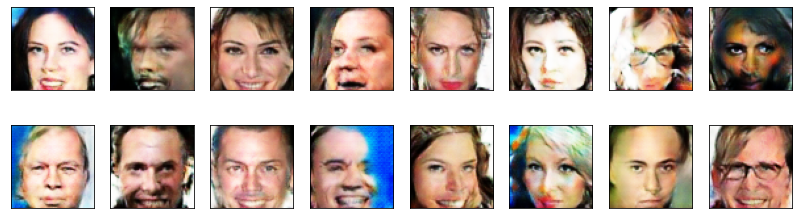

2024-11-23 18:22:30 | Epoch [24/30] | Batch 0/509 | d_loss: 1.2038 | g_loss: 0.9802
2024-11-23 18:22:40 | Epoch [24/30] | Batch 50/509 | d_loss: 1.2198 | g_loss: 0.8690
2024-11-23 18:22:51 | Epoch [24/30] | Batch 100/509 | d_loss: 1.1998 | g_loss: 0.8491
2024-11-23 18:23:04 | Epoch [24/30] | Batch 150/509 | d_loss: 1.2175 | g_loss: 0.8417
2024-11-23 18:23:19 | Epoch [24/30] | Batch 200/509 | d_loss: 1.1410 | g_loss: 1.1513
2024-11-23 18:23:35 | Epoch [24/30] | Batch 250/509 | d_loss: 1.3932 | g_loss: 1.0478
2024-11-23 18:23:59 | Epoch [24/30] | Batch 300/509 | d_loss: 1.1664 | g_loss: 1.1426
2024-11-23 18:24:26 | Epoch [24/30] | Batch 350/509 | d_loss: 1.1723 | g_loss: 1.1511
2024-11-23 18:24:56 | Epoch [24/30] | Batch 400/509 | d_loss: 1.2616 | g_loss: 0.9904
2024-11-23 18:25:26 | Epoch [24/30] | Batch 450/509 | d_loss: 1.1959 | g_loss: 0.9370
2024-11-23 18:25:57 | Epoch [24/30] | Batch 500/509 | d_loss: 1.3605 | g_loss: 0.6665


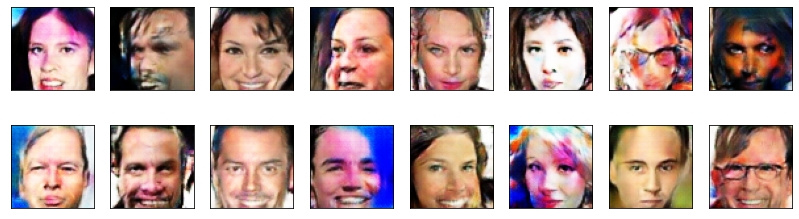

2024-11-23 18:26:06 | Epoch [25/30] | Batch 0/509 | d_loss: 1.2574 | g_loss: 0.9744
2024-11-23 18:26:16 | Epoch [25/30] | Batch 50/509 | d_loss: 1.0504 | g_loss: 1.1737
2024-11-23 18:26:27 | Epoch [25/30] | Batch 100/509 | d_loss: 1.1476 | g_loss: 0.9203
2024-11-23 18:26:40 | Epoch [25/30] | Batch 150/509 | d_loss: 1.2136 | g_loss: 0.9818
2024-11-23 18:26:55 | Epoch [25/30] | Batch 200/509 | d_loss: 1.1771 | g_loss: 0.9318
2024-11-23 18:27:11 | Epoch [25/30] | Batch 250/509 | d_loss: 1.1783 | g_loss: 0.9473
2024-11-23 18:27:35 | Epoch [25/30] | Batch 300/509 | d_loss: 1.1757 | g_loss: 0.9243
2024-11-23 18:28:02 | Epoch [25/30] | Batch 350/509 | d_loss: 1.3141 | g_loss: 1.1911
2024-11-23 18:28:32 | Epoch [25/30] | Batch 400/509 | d_loss: 1.1256 | g_loss: 0.9433
2024-11-23 18:29:02 | Epoch [25/30] | Batch 450/509 | d_loss: 1.3647 | g_loss: 0.9253
2024-11-23 18:29:33 | Epoch [25/30] | Batch 500/509 | d_loss: 1.3341 | g_loss: 0.8145


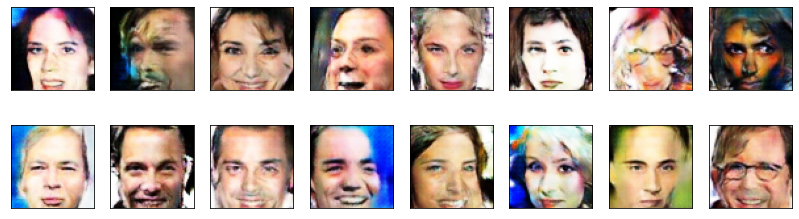

2024-11-23 18:29:42 | Epoch [26/30] | Batch 0/509 | d_loss: 1.3414 | g_loss: 0.7839
2024-11-23 18:29:52 | Epoch [26/30] | Batch 50/509 | d_loss: 1.2911 | g_loss: 0.8638
2024-11-23 18:30:02 | Epoch [26/30] | Batch 100/509 | d_loss: 1.2692 | g_loss: 0.8727
2024-11-23 18:30:15 | Epoch [26/30] | Batch 150/509 | d_loss: 1.2740 | g_loss: 0.8408
2024-11-23 18:30:30 | Epoch [26/30] | Batch 200/509 | d_loss: 1.2878 | g_loss: 0.9002
2024-11-23 18:30:46 | Epoch [26/30] | Batch 250/509 | d_loss: 1.2507 | g_loss: 0.8352
2024-11-23 18:31:11 | Epoch [26/30] | Batch 300/509 | d_loss: 1.2100 | g_loss: 1.0536
2024-11-23 18:31:38 | Epoch [26/30] | Batch 350/509 | d_loss: 1.2524 | g_loss: 0.8023
2024-11-23 18:32:07 | Epoch [26/30] | Batch 400/509 | d_loss: 1.9862 | g_loss: 0.6854
2024-11-23 18:32:37 | Epoch [26/30] | Batch 450/509 | d_loss: 1.3737 | g_loss: 0.8375
2024-11-23 18:33:08 | Epoch [26/30] | Batch 500/509 | d_loss: 1.4068 | g_loss: 0.9467


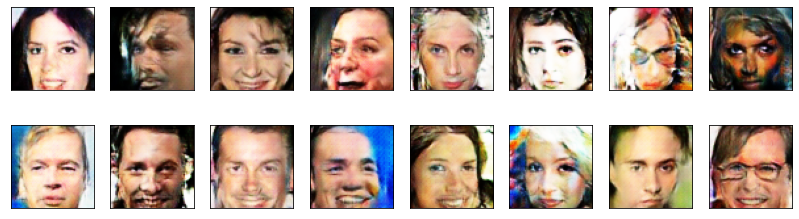

2024-11-23 18:33:17 | Epoch [27/30] | Batch 0/509 | d_loss: 1.4301 | g_loss: 0.8253
2024-11-23 18:33:26 | Epoch [27/30] | Batch 50/509 | d_loss: 1.2737 | g_loss: 1.0118
2024-11-23 18:33:37 | Epoch [27/30] | Batch 100/509 | d_loss: 1.3857 | g_loss: 1.9639
2024-11-23 18:33:50 | Epoch [27/30] | Batch 150/509 | d_loss: 1.1676 | g_loss: 1.0116
2024-11-23 18:34:05 | Epoch [27/30] | Batch 200/509 | d_loss: 1.2168 | g_loss: 0.8997
2024-11-23 18:34:21 | Epoch [27/30] | Batch 250/509 | d_loss: 1.3416 | g_loss: 1.1848
2024-11-23 18:34:45 | Epoch [27/30] | Batch 300/509 | d_loss: 1.1876 | g_loss: 1.1118
2024-11-23 18:35:12 | Epoch [27/30] | Batch 350/509 | d_loss: 1.1922 | g_loss: 0.8929
2024-11-23 18:35:42 | Epoch [27/30] | Batch 400/509 | d_loss: 1.0418 | g_loss: 1.3518
2024-11-23 18:36:12 | Epoch [27/30] | Batch 450/509 | d_loss: 1.4273 | g_loss: 0.7715
2024-11-23 18:36:43 | Epoch [27/30] | Batch 500/509 | d_loss: 1.3806 | g_loss: 0.9258


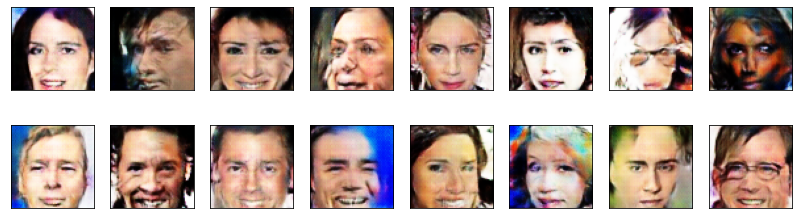

2024-11-23 18:36:51 | Epoch [28/30] | Batch 0/509 | d_loss: 1.4340 | g_loss: 0.7356
2024-11-23 18:37:01 | Epoch [28/30] | Batch 50/509 | d_loss: 1.3907 | g_loss: 0.7768
2024-11-23 18:37:11 | Epoch [28/30] | Batch 100/509 | d_loss: 1.3488 | g_loss: 0.9904
2024-11-23 18:37:24 | Epoch [28/30] | Batch 150/509 | d_loss: 1.3533 | g_loss: 0.7598
2024-11-23 18:37:39 | Epoch [28/30] | Batch 200/509 | d_loss: 1.2448 | g_loss: 0.9373
2024-11-23 18:37:55 | Epoch [28/30] | Batch 250/509 | d_loss: 1.3070 | g_loss: 0.9344
2024-11-23 18:38:19 | Epoch [28/30] | Batch 300/509 | d_loss: 1.3297 | g_loss: 0.7873
2024-11-23 18:38:47 | Epoch [28/30] | Batch 350/509 | d_loss: 1.1931 | g_loss: 0.8828
2024-11-23 18:39:16 | Epoch [28/30] | Batch 400/509 | d_loss: 1.2404 | g_loss: 0.9113
2024-11-23 18:39:46 | Epoch [28/30] | Batch 450/509 | d_loss: 1.0619 | g_loss: 0.9889
2024-11-23 18:40:17 | Epoch [28/30] | Batch 500/509 | d_loss: 1.5105 | g_loss: 0.6398


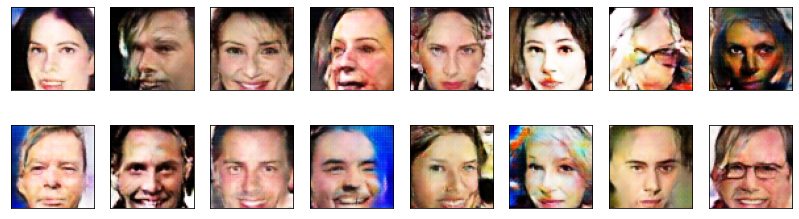

2024-11-23 18:40:27 | Epoch [29/30] | Batch 0/509 | d_loss: 1.3885 | g_loss: 0.8588
2024-11-23 18:40:36 | Epoch [29/30] | Batch 50/509 | d_loss: 1.1858 | g_loss: 0.9572
2024-11-23 18:40:47 | Epoch [29/30] | Batch 100/509 | d_loss: 1.2440 | g_loss: 0.8815
2024-11-23 18:41:00 | Epoch [29/30] | Batch 150/509 | d_loss: 1.2906 | g_loss: 1.0212
2024-11-23 18:41:15 | Epoch [29/30] | Batch 200/509 | d_loss: 1.2463 | g_loss: 0.8887
2024-11-23 18:41:31 | Epoch [29/30] | Batch 250/509 | d_loss: 1.4894 | g_loss: 0.7297
2024-11-23 18:41:55 | Epoch [29/30] | Batch 300/509 | d_loss: 1.3574 | g_loss: 0.7978
2024-11-23 18:42:22 | Epoch [29/30] | Batch 350/509 | d_loss: 1.2849 | g_loss: 0.8343
2024-11-23 18:42:52 | Epoch [29/30] | Batch 400/509 | d_loss: 1.2825 | g_loss: 0.8633
2024-11-23 18:43:22 | Epoch [29/30] | Batch 450/509 | d_loss: 1.2795 | g_loss: 0.9078
2024-11-23 18:43:53 | Epoch [29/30] | Batch 500/509 | d_loss: 1.2173 | g_loss: 0.9027


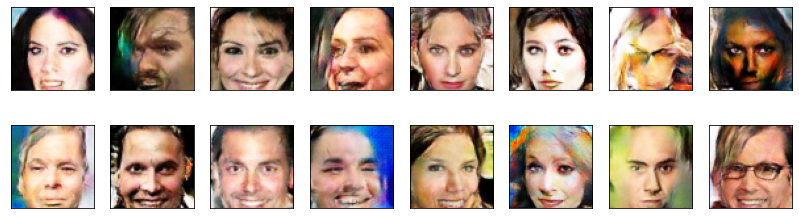

2024-11-23 18:44:02 | Epoch [30/30] | Batch 0/509 | d_loss: 1.1788 | g_loss: 0.9836
2024-11-23 18:44:12 | Epoch [30/30] | Batch 50/509 | d_loss: 1.2273 | g_loss: 0.8727
2024-11-23 18:44:23 | Epoch [30/30] | Batch 100/509 | d_loss: 1.1738 | g_loss: 0.8891
2024-11-23 18:44:36 | Epoch [30/30] | Batch 150/509 | d_loss: 1.1975 | g_loss: 0.8188
2024-11-23 18:44:51 | Epoch [30/30] | Batch 200/509 | d_loss: 1.1703 | g_loss: 1.0970
2024-11-23 18:45:07 | Epoch [30/30] | Batch 250/509 | d_loss: 1.2663 | g_loss: 0.9000
2024-11-23 18:45:31 | Epoch [30/30] | Batch 300/509 | d_loss: 1.1161 | g_loss: 0.9982
2024-11-23 18:45:58 | Epoch [30/30] | Batch 350/509 | d_loss: 1.1621 | g_loss: 1.7442
2024-11-23 18:46:28 | Epoch [30/30] | Batch 400/509 | d_loss: 1.1751 | g_loss: 1.2450
2024-11-23 18:46:58 | Epoch [30/30] | Batch 450/509 | d_loss: 1.3261 | g_loss: 0.8778
2024-11-23 18:47:28 | Epoch [30/30] | Batch 500/509 | d_loss: 1.3130 | g_loss: 1.1687


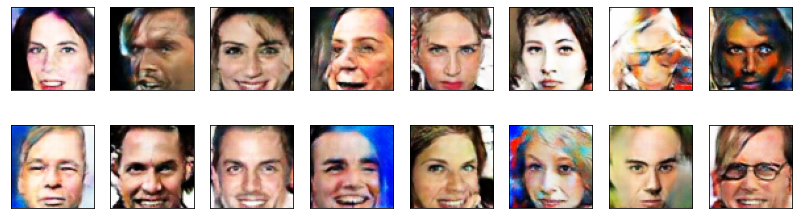

In [28]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        d_optimizer.zero_grad()
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        g_optimizer.zero_grad()
        g_loss = generator_step(batch_size, latent_dim)
        
        
        generator_step(batch_i, latent_dim)
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss']
            g = g_loss['loss']
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

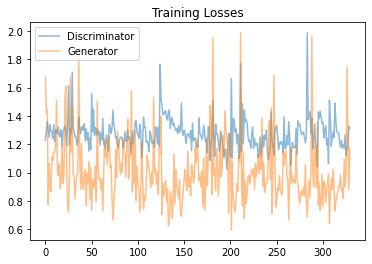

In [29]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

The generated samples appear to be biased, as the majority of the faces generated are predominantly white. To address this issue and improve diversity, increasing the model size has proven to be beneficial. Additionally, introducing Gaussian noise to the generated images can help enhance variability and mitigate the effects of bias in the outputs. By leveraging these techniques, the model can produce a wider range of realistic and unbiased facial features, ensuring better representation across different demographics.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.